## 1. 定义算法

Double DQN (DDQN), DQN有一个显著的问题，就是DQN估计的Q值往往会偏大。这是由于我们Q值是以下一个s'的Q值的最大值来估算的，但下一个state的Q值也是一个估算值，也依赖它的下一个state的Q值...，这就导致了Q值往往会有偏大的的情况出现。DDQN的思路也很直观。如果只有一个Q网络，它不是经常吹牛，导致Q值往往会偏大。那我就用两个Q网络，因为两个Q网络的参数有差别，所以对于同一个动作的评估也会有少许不同。我们选取评估出来较小的值来计算目标。这样就能避免Q网络吹牛的情况发生了。



### 1.1 定义模型

In [31]:
import parl
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

class MLP(parl.Model):
    """ Linear network to solve Cartpole problem.
    Args:
        input_dim (int): Dimension of observation space.
        output_dim (int): Dimension of action space.
    """

    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        hidden_dim1 = 256
        hidden_dim2 = 256
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 1.2 定义经验回放

In [32]:
from collections import deque
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

### 1.3 定义智能体

In [33]:
from random import random
import parl
import paddle
import math
import numpy as np


class DDQNAgent(parl.Agent):
    """Agent of DDQN.
    """

    def __init__(self, algorithm, memory,cfg):
        super(DDQNAgent, self).__init__(algorithm)
        self.n_actions = cfg['n_actions']
        self.epsilon = cfg['epsilon_start']
        self.sample_count = 0
        self.epsilon_start = cfg['epsilon_start']
        self.epsilon_end = cfg['epsilon_end']
        self.epsilon_decay = cfg['epsilon_decay']
        self.batch_size = cfg['batch_size']
        self.global_step = 0
        self.update_target_steps = 600
        self.memory = memory # replay buffer

    def sample_action(self, state):
        self.sample_count += 1
        # epsilon must decay(linear,exponential and etc.) for balancing exploration and exploitation
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay)
        if  random.random() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            action = self.predict_action(state)
        return action

    def predict_action(self, state):
        state = paddle.to_tensor(state , dtype='float32')
        q_values = self.alg.predict(state) # self.alg 是自带的算法
        action = q_values.argmax().numpy()[0]
        return action

    def update(self):
        """Update model with an episode data
        Args:
            obs(np.float32): shape of (batch_size, obs_dim)
            act(np.int32): shape of (batch_size)
            reward(np.float32): shape of (batch_size)
            next_obs(np.float32): shape of (batch_size, obs_dim)
            terminal(np.float32): shape of (batch_size)
        Returns:
            loss(float)
        """
        if len(self.memory) < self.batch_size: # when transitions in memory donot meet a batch, not update
            return

        if self.global_step % self.update_target_steps == 0:
            self.alg.sync_target()
        self.global_step += 1
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        action_batch = np.expand_dims(action_batch, axis=-1)
        reward_batch = np.expand_dims(reward_batch, axis=-1)
        done_batch = np.expand_dims(done_batch, axis=-1)

        state_batch = paddle.to_tensor(state_batch, dtype='float32')
        action_batch = paddle.to_tensor(action_batch, dtype='int32')
        reward_batch = paddle.to_tensor(reward_batch, dtype='float32')
        next_state_batch = paddle.to_tensor(next_state_batch, dtype='float32')
        done_batch = paddle.to_tensor(done_batch, dtype='float32')
        loss = self.alg.learn(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

## 2. 定义训练

In [34]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print(f"开始训练！")
    print(f"环境：{cfg['env_name']}，算法：{cfg['algo_name']}，设备：{cfg['device']}")
    rewards = []  # record rewards for all episodes
    steps = []
    for i_ep in range(cfg["train_eps"]):
        ep_reward = 0  # reward per episode
        ep_step = 0
        state = env.reset()[0]  # reset and obtain initial state
        for _ in range(cfg['ep_max_steps']):
            ep_step += 1
            action = agent.sample_action(state)  # sample action
            next_state, reward, done, *_ = env.step(action)  # update env and return transitions
            agent.memory.push((state, action, reward,next_state, done))  # save transitions
            state = next_state  # update next state for env
            agent.update()  # update agent
            ep_reward += reward  #
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}，Epislon: {agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    res_dic = {'episodes':range(len(rewards)),'rewards':rewards,'steps':steps}
    return res_dic

def test(cfg, env, agent):
    print("开始测试！")
    print(f"环境：{cfg['env_name']}，算法：{cfg['algo_name']}，设备：{cfg['device']}")
    rewards = []  # record rewards for all episodes
    steps = []
    for i_ep in range(cfg['test_eps']):
        ep_reward = 0  # reward per episode
        ep_step = 0
        state = env.reset()[0]  # reset and obtain initial state
        for _ in range(cfg['ep_max_steps']):
            ep_step+=1
            action = agent.predict_action(state)  # predict action
            next_state, reward, done, *_ = env.step(action)
            state = next_state
            ep_reward += reward
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    env.close()
    return {'episodes':range(len(rewards)),'rewards':rewards,'steps':steps}


## 3. 定义环境

In [35]:
import gym
import paddle
import numpy as np
import random
import os
from parl.algorithms import DDQN
def all_seed(env,seed = 1):
    ''' omnipotent seed for RL, attention the position of seed function, you'd better put it just following the env create function
    Args:
        env (_type_):
        seed (int, optional): _description_. Defaults to 1.
    '''
    print(f"seed = {seed}")
    env.reset(seed=seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    paddle.seed(seed)

def env_agent_config(cfg):
    ''' create env and agent
    '''
    env = gym.make(cfg['env_name'])
    if cfg['seed'] !=0: # set random seed
        all_seed(env,seed=cfg["seed"])
    n_states = env.observation_space.shape[0] # print(hasattr(env.observation_space, 'n'))
    n_actions = env.action_space.n  # action dimension
    print(f"n_states: {n_states}, n_actions: {n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # update to cfg paramters
    model = MLP(n_states,n_actions)
    algo = DDQN(model, gamma=cfg['gamma'], lr=cfg['lr'])
    memory =  ReplayBuffer(cfg["memory_capacity"]) # replay buffer
    agent = DDQNAgent(algo,memory,cfg)  # create agent
    return env, agent

## 4. 设置参数

In [36]:
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
def get_args():
    """
    """
    parser = argparse.ArgumentParser(description="hyperparameters")
    parser.add_argument('--algo_name',default='DDQN',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='CartPole-v0',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=200,type=int,help="episodes of training") # 训练的回合数
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing") # 测试的回合数
    parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.98,type=float,help="discounted factor") # 折扣因子
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon") #  e-greedy策略中初始epsilon
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon") # e-greedy策略中的终止epsilon
    parser.add_argument('--epsilon_decay',default=200,type=int,help="decay rate of epsilon") # e-greedy策略中epsilon的衰减率
    parser.add_argument('--memory_capacity',default=200000,type=int) # replay memory的容量
    parser.add_argument('--memory_warmup_size',default=200,type=int) # replay memory的预热容量
    parser.add_argument('--batch_size',default=64,type=int,help="batch size of training") # 训练时每次使用的样本数
    parser.add_argument('--targe_update_fre',default=200,type=int,help="frequency of target network update") # target network更新频率
    parser.add_argument('--seed',default=10,type=int,help="seed")
    parser.add_argument('--lr',default=0.001,type=float,help="learning rate")
    parser.add_argument('--device',default='cpu',type=str,help="cpu or gpu")
    args = parser.parse_args([])
    args = {**vars(args)}  # type(dict)
    return args
def smooth(data, weight=0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

def plot_rewards(rewards,cfg,path=None,tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. 收获成果！

seed = 10
n_states: 4, n_actions: 2
开始训练！
环境：CartPole-v0，算法：DDQN，设备：cpu
回合：10/200，奖励：19.00，Epislon: 0.337
回合：20/200，奖励：9.00，Epislon: 0.156
回合：30/200，奖励：11.00，Epislon: 0.094
回合：40/200，奖励：13.00，Epislon: 0.056
回合：50/200，奖励：10.00，Epislon: 0.036
回合：60/200，奖励：9.00，Epislon: 0.024
回合：70/200，奖励：14.00，Epislon: 0.017
回合：80/200，奖励：10.00，Epislon: 0.014
回合：90/200，奖励：9.00，Epislon: 0.013
回合：100/200，奖励：33.00，Epislon: 0.011
回合：110/200，奖励：18.00，Epislon: 0.010
回合：120/200，奖励：16.00，Epislon: 0.010
回合：130/200，奖励：14.00，Epislon: 0.010
回合：140/200，奖励：164.00，Epislon: 0.010
回合：150/200，奖励：185.00，Epislon: 0.010
回合：160/200，奖励：159.00，Epislon: 0.010
回合：170/200，奖励：197.00，Epislon: 0.010
回合：180/200，奖励：133.00，Epislon: 0.010
回合：190/200，奖励：129.00，Epislon: 0.010
回合：200/200，奖励：224.00，Epislon: 0.010
完成训练！
开始测试！
环境：CartPole-v0，算法：DDQN，设备：cpu
回合：1/20，奖励：117.00
回合：2/20，奖励：113.00
回合：3/20，奖励：116.00
回合：4/20，奖励：112.00
回合：5/20，奖励：116.00
回合：6/20，奖励：114.00
回合：7/20，奖励：119.00
回合：8/20，奖励：112.00
回合：9/20，奖励：110.00
回合：10/20，奖励：111.00
回合：11/20，奖

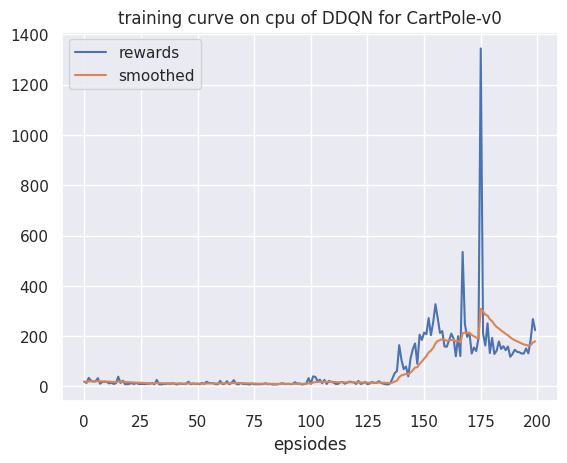

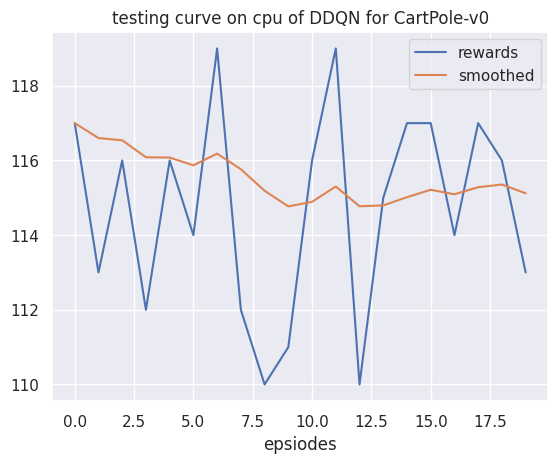

In [37]:
# 获取参数
cfg = get_args()
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)

plot_rewards(res_dic['rewards'], cfg, tag="train")
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果